<a href="https://colab.research.google.com/github/leekate/Kaggle-petals-to-the-metal/blob/main/petals_to_the_metal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

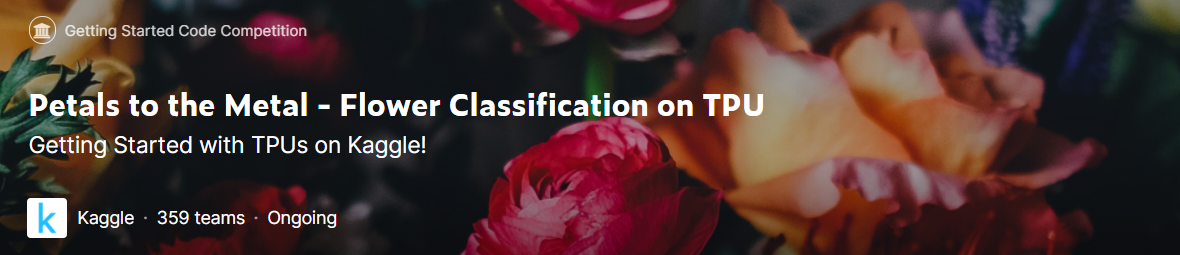

## Kaggle- petals to the metal
**Classifying 104 types of flowers** based on their images drawn from five different public datasets. Some classes are very narrow, containing only a particular sub-type of flower while other classes contain many sub-types.


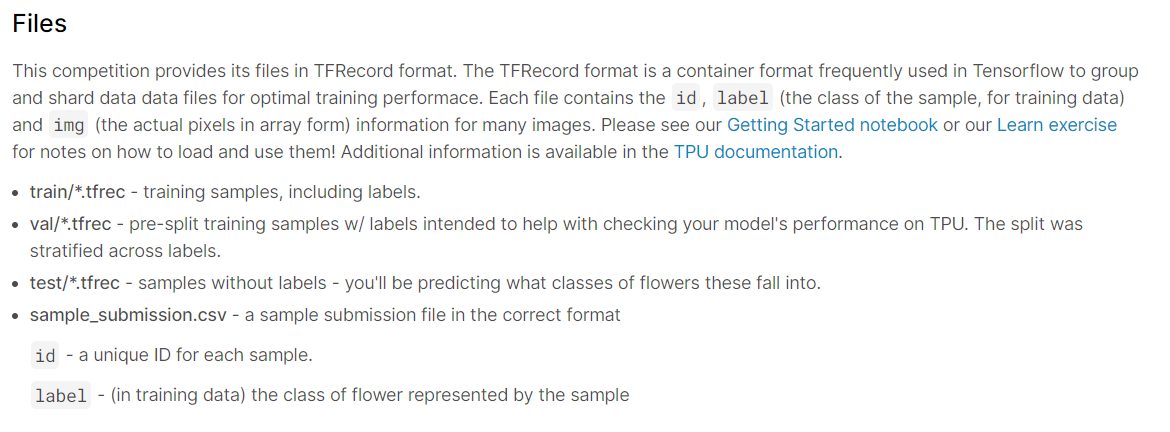

**sample과 label이 포함**되어 있는 데이터셋이다. 데이터 로드 후 unzip까지 해보자. 

In [ ]:
# from kaggle_datasets import KaggleDatasets
# GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
# print(GCS_DS_PATH)

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle competitions download -c tpu-getting-started

 45% 5.00M/11.1M [00:00<00:00, 31.4MB/s]
100% 11.1M/11.1M [00:00<00:00, 43.7MB/s]
 65% 7.00M/10.8M [00:00<00:00, 71.9MB/s]
100% 10.8M/10.8M [00:00<00:00, 68.7MB/s]
 82% 9.00M/11.0M [00:00<00:00, 16.5MB/s]
100% 11.0M/11.0M [00:00<00:00, 18.6MB/s]
 46% 5.00M/10.8M [00:00<00:00, 33.7MB/s]
100% 10.8M/10.8M [00:00<00:00, 53.0MB/s]
 85% 9.00M/10.6M [00:00<00:00, 36.2MB/s]
100% 10.6M/10.6M [00:00<00:00, 35.1MB/s]
 82% 9.00M/11.0M [00:00<00:00, 41.7MB/s]
100% 11.0M/11.0M [00:00<00:00, 43.6MB/s]
 73% 8.00M/11.0M [00:00<00:00, 81.2MB/s]
100% 11.0M/11.0M [00:00<00:00, 70.2MB/s]
 82% 9.00M/10.9M [00:00<00:00, 26.8MB/s]
100% 10.9M/10.9M [00:00<00:00, 30.9MB/s]
100% 10.9M/10.9M [00:00<00:00, 112MB/s]

 83% 9.00M/10.8M [00:00<00:00, 79.2MB/s]
100% 10.8M/10.8M [00:00<00:00, 68.1MB/s]
 83% 9.00M/10.8M [00:00<00:00, 22.7MB/s]
100% 10.8M/10.8M [00:00<00:00, 21.9MB/s]
 82% 9.00M/10.9M [00:00<00:00, 21.3MB/s]
100% 10.9M/10.9M [00:00<00:00, 24.7MB/s]
 46% 5.00M/10.8M [00:00<00:00, 38.6MB/s]
100% 10.8M/10.8M

In [ ]:
!unzip \*.zip

Archive:  04-512x512-462.tfrec.zip
  inflating: 04-512x512-462.tfrec    

Archive:  06-224x224-462.tfrec.zip
  inflating: 06-224x224-462.tfrec    

Archive:  15-224x224-232.tfrec.zip
  inflating: 15-224x224-232.tfrec    

Archive:  03-512x512-462.tfrec.zip
  inflating: 03-512x512-462.tfrec    

Archive:  02-512x512-232.tfrec.zip
  inflating: 02-512x512-232.tfrec    

Archive:  07-224x224-462.tfrec.zip
  inflating: 07-224x224-462.tfrec    

Archive:  12-224x224-798.tfrec.zip
  inflating: 12-224x224-798.tfrec    

Archive:  10-512x512-462.tfrec.zip
  inflating: 10-512x512-462.tfrec    

Archive:  06-512x512-232.tfrec.zip
  inflating: 06-512x512-232.tfrec    

Archive:  10-512x512-232.tfrec.zip
  inflating: 10-512x512-232.tfrec    

Archive:  02-512x512-798.tfrec.zip
  inflating: 02-512x512-798.tfrec    

Archive:  00-512x512-232.tfrec.zip
  inflating: 00-512x512-232.tfrec    

Archive:  00-512x512-798.tfrec.zip
  inflating: 00-512x512-798.tfrec    

Archive:  00-224x224-462.tfrec.zip
  i

In [ ]:
# import os
# import numpy as np
# from PIL import Image

# for i in range (0,15):
#   path1 = i+"./"+i+"/*.tfrec"
#   file_list = os.listdir(path1)
#   n=len(file_list)
#   print (i+"'s length: {}".format(n))
#   i=i+1


## Problem-Label
아래 에러를 살펴보니 Label데이터의 문제인 것 같다. 

Label data의 Load부터 새로 해주어야 할 거 같은데 **Label data를 어떻게 수정할 수 있을까?**
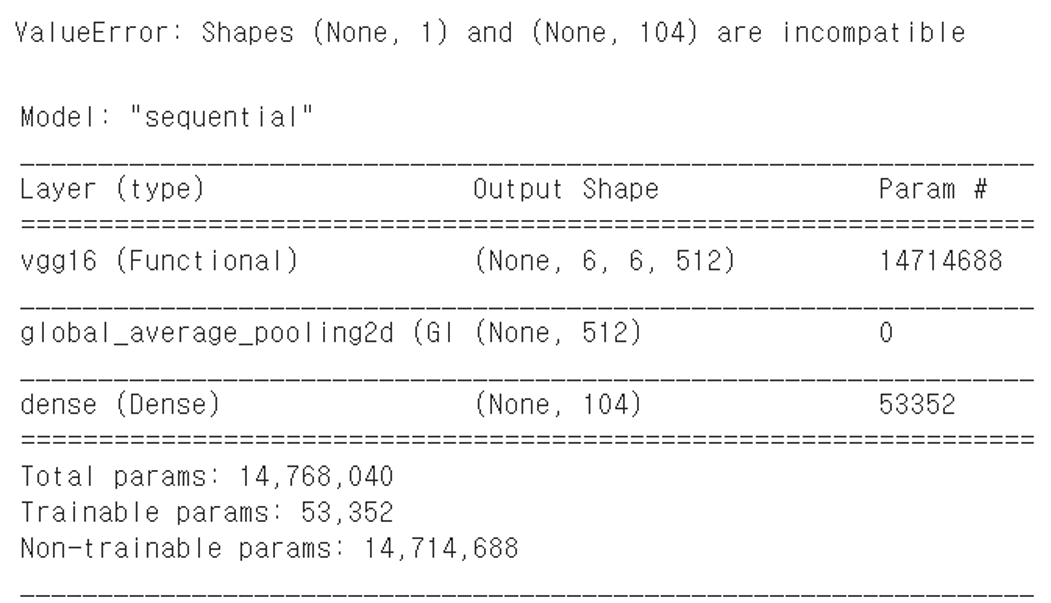

In [ ]:
import math, re, os
import numpy as np
import tensorflow as tf

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.95.249.114:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.95.249.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.95.249.114:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Loading the Competition Data

In [ ]:
IMAGE_SIZE = [192, 192] # TPU 쓰기
EPOCHS = 5
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset



In [ ]:
def get_training_dataset():
    dataset = load_dataset(tf.io.gfile.glob('./tfrecords-jpeg-192x192/train/*.tfrec'), labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(tf.io.gfile.glob('./tfrecords-jpeg-192x192/val/*.tfrec'), labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(tf.io.gfile.glob('./tfrecords-jpeg-192x192/test/*.tfrec'), labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

test_dataset = get_test_dataset()

In [ ]:
with strategy.scope():    
    pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = False # tramsfer learning
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(104, activation='softmax')
    ])
        
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['categorical_accuracy']
)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 104)               53352     
Total params: 14,768,040
Trainable params: 53,352
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
training_dataset

<BatchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
validation_dataset

<CacheDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
historical = model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          validation_data=validation_dataset)

Epoch 1/5


ValueError: ignored

# Test

In [ ]:
test_ds = get_test_dataset(ordered=True) 

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), 
           fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')